In [1]:
import os, sys
sys.path.insert(0, '/home/groups/rwr/alpv95/tracksml')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from astropy.io import fits
from xspec import *
from ixpeobssim.binning.polarization import xBinnedPolarizationCube, xBinnedPolarizationTimeCube
import subprocess
import heasoftpy as hsp
import math



plt.style.use('/home/groups/rwr/alpv95/util/plot.mplstyle')
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%matplotlib inline
home_dir = '/home/groups/rwr/alpv95/tracksml/moments/'
data_dir = '/home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/'

### Useful Functions

In [2]:
def pol_posterior(pi0, phi0, Neff, pi=0, phi=0, mu100=1):
    '''Full 2 dimensional posterior distribution for pi and phi, 
      assuming uniform prior in Pi-phi space.'''
    sigma = np.sqrt(1/Neff * (1 - pi0**2*mu100**2/2))
    return np.sqrt(Neff) * pi*mu100**2 / (2*np.pi*sigma) * np.exp(-mu100**2/(4*sigma**2)
            *(pi0**2 + pi**2 -2*pi*pi0*np.cos(2*(phi - phi0)) - pi**2*pi0**2*mu100**2/2 
            * np.sin(2*(phi-phi0))**2))
  
def qu_posterior(q0, u0, Neff, q=0, u=0, mu100=1, prior_on=False):
    '''Full 2 dimensional posterior distribution for q and u.
      Flat prior in pi-phi space means non-uniform prior in q-u.
      Can turn prior on or off.'''
    sigma_q = np.sqrt(1/Neff * (2/mu100**2 - q0**2))
    sigma_u = np.sqrt(1/Neff * (2/mu100**2 - u0**2))
    corr = (-q0*u0 / Neff) / (sigma_q * sigma_u) 
    prior = 1
    if prior_on:
      prior = 1 / (2*np.pi * np.sqrt(q0**2 + u0**2))
    return prior * 1 / (2*np.pi*sigma_q*sigma_u*np.sqrt(1-corr**2)) * np.exp(-1/(2*(1-corr**2))
            *((q - q0)**2/sigma_q**2 + (u-u0)**2/sigma_u**2 
            - (2*corr*(q-q0)*(u-u0))/(sigma_q*sigma_u)))
  
def qu_likelihood(q, u, Neff, q0=0, u0=0, mu100=1):
    '''Full 2 dimensional posterior distribution for q and u, assuming uniform prior in Pi-phi space.'''
    sigma_q = np.sqrt(1/Neff * (2/mu100**2 - q0**2))
    sigma_u = np.sqrt(1/Neff * (2/mu100**2 - u0**2))
    corr = (-q0*u0 / Neff) / (sigma_q * sigma_u) 
    prior = 1
    return prior * 1 / (2*np.pi*sigma_q*sigma_u*np.sqrt(1-corr**2)) * np.exp(-1/(2*(1-corr**2))
            *((q - q0)**2/sigma_q**2 + (u-u0)**2/sigma_u**2 
            - (2*corr*(q-q0)*(u-u0))/(sigma_q*sigma_u)))

def CL(Z, dx, dy=1, p=0.68, tol=0.005, max_iter=1000):
    '''
    Gets highest posterior density Confidence level for contour plot for 2d posterior.
    Z_norm is the 2d grid of normalized posterior values
    Also gets 1d posterior confidence region.
    '''
    integral = np.sum(Z*dx*dy)
    if not math.isclose(integral,1):
        Z = Z / integral
    x = 0
    i = 0
    const = np.max(Z)/max_iter
    while np.abs(np.sum(Z[Z >= np.max(Z)-x]*dx*dy) - p) > tol and i < max_iter:
        x += const
        i += 1
    if i >= max_iter:
        print('Max iterations reached, need to lower tolerance.')
        return 
    if dy == 1: #1d posterior
        idxs = np.where(Z >= np.max(Z)-x)[0]
        return np.max(Z) - x, min(idxs), max(idxs)
    return np.max(Z) - x

def upper_CL(Z, x, p=0.68, tol=0.005):
    '''For 1d distribution with minimum at zero
        Assumes sorted x and Z starting from 0.
        Returns actual upper limit.'''
    dx = x[1] - x[0]
    integral = np.sum(Z*dx)
    if not math.isclose(integral,1):
        print("input posterior not normalized")
        Z = Z / integral
    i = 0
    const = np.max(Z)/200
    while np.abs(np.sum(Z[x <= x[i]]*dx) - p) > tol and i < len(x):
        i += 1
    if i >= len(x):
        print('Max iterations reached, need to lower tolerance.')
        return 
    return x[i]

## Example Correction README for early observations.
This file applies the IXPE observation of Mrk 421 OBSID=01003801 released in Jun 2022.

Mirror Module Vignetting: there is a small error in alignment of the mirror module's optical axes with respect to the telescope axes (which are at the center of the detectors). The magnitude of this misalignment is estimated to be around 3 arcmin. The consequence of this is that the effective area may be >5% lower than expected.

Alignment: We are using the average position derived from the X-ray aspect to remove detector to detector pointing errors.  The absolute coordinates are still slightly off.  To correct these coordinates, run fmodhead on all three event2 files with the following modification:

TCRPX7  =   292.8
TCRPX8  =   308.6

Energy Calibration: there is an error currently in the energy scale corresponding to 0.8 keV at the iron line (note that the shift is smaller at the silicon line) based on on-board calibration data. A single scaling factor plus an offset applied to the channel number (PI) will provide a good correction, within 1%. This scaling factor and offset are given below for the 3 telescopes, to be applied as follows:  PI (corrected) = PI * slope + offset.

System   Gain Correction Coefficients
         Slope    Offset
DU1      0.912    2.4
DU2      0.857    2.3
DU3      0.902    2.0

---

## Level 2 Data preprocessing

This part is external to the jupyter notebook, although in principle it could be incorporated. I just find it easier to deal with ds9 externally.

In [ ]:
ftcopy 'ixpe01003901_det3_evt1_v01_filter_recon_nn_stokes_adj_w_j2000.fits[1][col TRG_ID; TIME; STATUS; STATUS2; W_MOM; PI; X; Y; Q; U; W_NN; FLAG; P_TAIL]' ixpe01003901_det3_nn.fits
# tempfile for NN has TCP 10, 11
# Can use same region files for NN and moments, coords should be almost exactly the same.

## Procedure

- Correct headers for WCS
    
    ```bash
    fthedit ixpe_det?.fits @tempfile.txt
    ```
    
- Re-calibrate pulse invariants
    
    ```bash
    xppicorr --slope 0.921 --offset 2.2 --overwrite False ixpe_det1.fits
    ```
    
- Make `src` and `bkg` region files in ds9. Standard is 60 arcsec circles for both or a 90 arsec source circle and a big annulus around it for the background.
    
    ```bash
    det1_src.reg, det1_bkg.reg
    ```
    
- Use `xpselect` to extract appropriate regions.
    
    ```bash
    xpselect --regfile det1_src.reg --suffix src {--emin --emax} ixpe_det1_picorr.fits
    xpselect --regfile det1_bkg.reg --suffix bkg {--emin --emax} ixpe_det1_picorr.fits
    ```
    
- `xpbin` to bin observations using the appropriate algorithms. Can be weighted or unweighted and with or without acceptance correction. See below for further steps.


---

## Spectro-Polarimetric Analysis

In [15]:
#Define directories and filenames.
obs = 9
subdir = f'mrk421/01003{obs}01/event_l2/'
det_files = [f'ixpe01003{obs}01_det1_evt2_v03_picorr', 
             f'ixpe01003{obs}01_det2_evt2_v03_picorr', 
             f'ixpe01003{obs}01_det3_evt2_v03_picorr']
det_nn_files = [f'ixpe01003{obs}01_det1_nn_picorr', 
             f'ixpe01003{obs}01_det2_nn_picorr', 
             f'ixpe01003{obs}01_det3_nn_picorr']
xpsim_bin = '/home/users/alpv95/khome/tracksml/moments/ixpeobssim/ixpeobssim/bin/'

### Preprocessing

This step comes after ds9 source and background regions have been selected using `xpselect`.

In [18]:
#Weighted and unweighted PCUBE analysis
t_bins = 7
tmin = 171362993.51
tmax = 171539479.125
for alg in ['PTCUBE']:
  for kind in ['_src','_bkg']:
    for filename in det_nn_files:
      !python3 {xpsim_bin}xpbin.py --suffix nnwptcube --acceptcorr=False --weights=True --weightcol W_NN --irfname ixpe:obssim_nnw:v11 --algorithm {alg} --tbinalg LIN --tbins {t_bins} --tmin {tmin} --tmax {tmax} {data_dir + subdir + filename + kind +'.fits'}
          
    for filename in det_files:
      !python3 {xpsim_bin}xpbin.py --suffix ptcube --acceptcorr=False --irfname ixpe:obssim:v11 --algorithm {alg} --tbinalg LIN --tbins {t_bins} --tmin {tmin} --tmax {tmax} {data_dir + subdir + filename + kind +'.fits'}


    Welcome to ixpeobssim 29.3.1 (built on Thu, 06 Oct 2022 22:12:32 +0200).

    Copyright (C) 2015--2022, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

>>> Opening input event file /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det1_nn_picorr_src.fits...
Filename: /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det1_nn_picorr_src.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      53   ()      
  1  EVENTS        1 BinTableHDU    223   97953R x 13C   [1J, 1D, 16X, 16X, 1J, E, E, J, 1E, D, D, D, D]   
  2  GTI           1 BinTableHDU     37   66R x 2C   [1D, 1D]   
>>> Reading WCS information from the EVENTS HDU...



    Welcome to ixpeobssim 29.3.1 (built on Thu, 06 Oct 2022 22:12:32 +0200).

    Copyright (C) 2015--2022, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

>>> Opening input event file /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det3_nn_picorr_src.fits...
Filename: /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det3_nn_picorr_src.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      53   ()      
  1  EVENTS        1 BinTableHDU    223   85905R x 13C   [1J, 1D, 16X, 16X, 1J, E, E, J, 1E, D, D, D, D]   
  2  GTI           1 BinTableHDU     37   66R x 2C   [1D, 1D]   
>>> Reading WCS information from the EVENTS HDU...



    Welcome to ixpeobssim 29.3.1 (built on Thu, 06 Oct 2022 22:12:32 +0200).

    Copyright (C) 2015--2022, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

>>> Opening input event file /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det2_evt2_v03_picorr_src.fits...
Filename: /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det2_evt2_v03_picorr_src.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      70   ()      
  1  EVENTS        1 BinTableHDU    216   69725R x 10C   [J, D, 16X, 16X, J, E, E, E, D, D]   
  2  GTI           1 BinTableHDU     55   78R x 2C   [D, D]   
>>> Reading WCS information from the EVENTS HDU...
ima


    Welcome to ixpeobssim 29.3.1 (built on Thu, 06 Oct 2022 22:12:32 +0200).

    Copyright (C) 2015--2022, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

>>> Opening input event file /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det1_nn_picorr_bkg.fits...
Filename: /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det1_nn_picorr_bkg.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      53   ()      
  1  EVENTS        1 BinTableHDU    223   5646R x 13C   [1J, 1D, 16X, 16X, 1J, E, E, J, 1E, D, D, D, D]   
  2  GTI           1 BinTableHDU     37   66R x 2C   [1D, 1D]   
>>> Reading WCS information from the EVENTS HDU...
i


    Welcome to ixpeobssim 29.3.1 (built on Thu, 06 Oct 2022 22:12:32 +0200).

    Copyright (C) 2015--2022, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

>>> Opening input event file /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det3_nn_picorr_bkg.fits...
Filename: /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det3_nn_picorr_bkg.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      53   ()      
  1  EVENTS        1 BinTableHDU    223   4801R x 13C   [1J, 1D, 16X, 16X, 1J, E, E, J, 1E, D, D, D, D]   
  2  GTI           1 BinTableHDU     37   66R x 2C   [1D, 1D]   
>>> Reading WCS information from the EVENTS HDU...
i


    Welcome to ixpeobssim 29.3.1 (built on Thu, 06 Oct 2022 22:12:32 +0200).

    Copyright (C) 2015--2022, the ixpeobssim team.

    ixpeobssim comes with ABSOLUTELY NO WARRANTY.
    This is free software, and you are welcome to redistribute it under certain
    conditions. See the LICENSE file for details.

    Visit https://bitbucket.org/ixpesw/ixpeobssim for more information.

>>> Opening input event file /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det2_evt2_v03_picorr_bkg.fits...
Filename: /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det2_evt2_v03_picorr_bkg.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      70   ()      
  1  EVENTS        1 BinTableHDU    216   4484R x 10C   [J, D, 16X, 16X, J, E, E, E, D, D]   
  2  GTI           1 BinTableHDU     55   78R x 2C   [D, D]   
>>> Reading WCS information from the EVENTS HDU...
imag

---

## PCUBES

In [19]:
#background area scaling
# scale = 0.142 # obs38
scale = 0.1824 # obs39

cubes = []
for kind in ['_src','_bkg']:
  for files, ext in zip([det_files, det_nn_files], ['ptcube', 'nnwptcube']):
    cubes.append(xBinnedPolarizationTimeCube.from_file_list([
      data_dir + subdir + f + f"{kind}_{ext}.fits"
      for f in files]))
      
#For background subtraction
cubes_subt = []
for kind in ['_src']:
  for files, ext in zip([det_files, det_nn_files], ['ptcube', 'nnwptcube']):
    cubes_subt.append(xBinnedPolarizationTimeCube.from_file_list([
      data_dir + subdir + f + f"{kind}_{ext}.fits"
      for f in files]))

#Apply background subtraction, with appropriate area scaling
for i,cube in enumerate(cubes_subt):
  cubes[i+2] *= scale
  cube -= cubes[i+2]

>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det1_evt2_v03_picorr_src_ptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     55   77R x 2C   ['D', 'D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det2_evt2_v03_picorr_src_ptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     55   78R x 2C   ['D', 'D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det3_evt2_v03_picorr_src_ptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     55   79R x 2C   ['D', 'D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det1_nn_picorr_src_nnwptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     37   66R x 2C   ['1D', '1D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det2_nn_picorr_src_nnwptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     37   62R x 2C   ['1D', '1D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det3_nn_picorr_src_nnwptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     37   66R x 2C   ['1D', '1D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det1_evt2_v03_picorr_bkg_ptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     55   77R x 2C   ['D', 'D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det2_evt2_v03_picorr_bkg_ptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     55   78R x 2C   ['D', 'D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det3_evt2_v03_picorr_bkg_ptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     55   79R x 2C   ['D', 'D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det1_nn_picorr_bkg_nnwptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     37   66R x 2C   ['1D', '1D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det2_nn_picorr_bkg_nnwptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     37   62R x 2C   ['1D', '1D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det3_nn_picorr_bkg_nnwptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     37   66R x 2C   ['1D', '1D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det1_evt2_v03_picorr_src_ptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     55   77R x 2C   ['D', 'D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det2_evt2_v03_picorr_src_ptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     55   78R x 2C   ['D', 'D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det3_evt2_v03_picorr_src_ptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     55   79R x 2C   ['D', 'D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det1_nn_picorr_src_nnwptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     37   66R x 2C   ['1D', '1D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det2_nn_picorr_src_nnwptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     37   62R x 2C   ['1D', '1D']   


>>> Reading (in memory) /home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/mrk421/01003901/event_l2/ixpe01003901_det3_nn_picorr_src_nnwptcube.fits...


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   ()      
  1  POLARIZATION    1 BinTableHDU     90   7R x 28C   ['D', 'D', 'D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
  2  GTI           1 BinTableHDU     37   66R x 2C   ['1D', '1D']   


### Sanity Check

[0.07721626 0.09627823 0.09113973 0.08513061 0.14648268 0.11369953
 0.10602179]


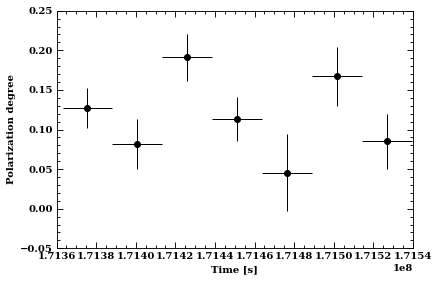

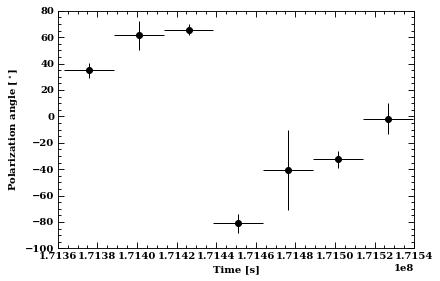

In [20]:
cubes_subt[0].plot_polarization_degree(min_num_sigmas=0)
plt.figure()
cubes_subt[0].plot_polarization_angle()
print(cubes_subt[0].MDP_99)

[0.05739384 0.07185356 0.06825512 0.06364662 0.10998036 0.08527024
 0.07970364]


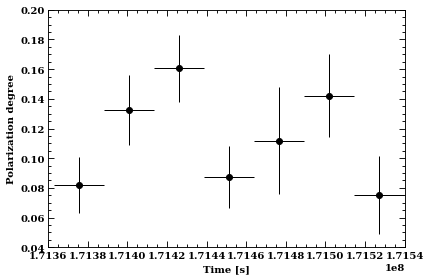

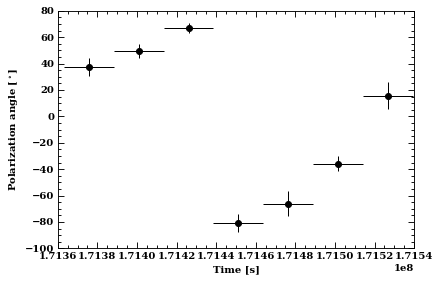

In [21]:
cubes_subt[1].plot_polarization_degree(min_num_sigmas=0)
plt.figure()
cubes_subt[1].plot_polarization_angle()
print(cubes_subt[1].MDP_99)

[0.10893208 0.11852146 0.12096605 0.10972372 0.12408802 0.11202416
 0.08992674]


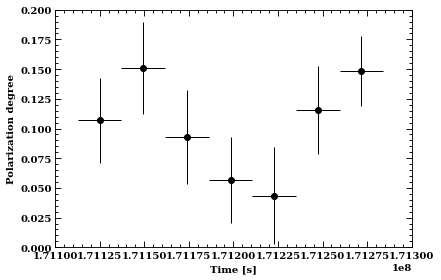

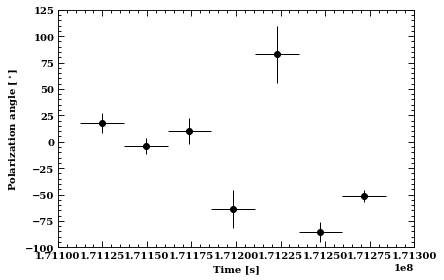

In [14]:
cubes_subt[0].plot_polarization_degree(min_num_sigmas=0)
plt.figure()
cubes_subt[0].plot_polarization_angle()
print(cubes_subt[0].MDP_99)

[0.09238423 0.10095891 0.10303335 0.09297824 0.10538324 0.09493958
 0.07611512]


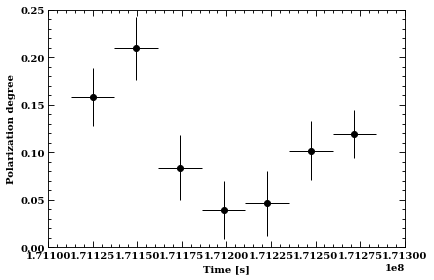

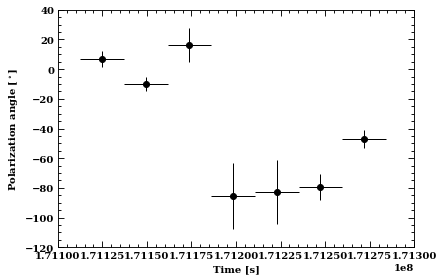

In [13]:
cubes_subt[1].plot_polarization_degree(min_num_sigmas=0)
plt.figure()
cubes_subt[1].plot_polarization_angle()
print(cubes_subt[1].MDP_99)

In [20]:
cubes_subt[0].PD_ERR

array([0.04775193, 0.05374981, 0.05632695, 0.05503972, 0.04802841,
       0.05109166, 0.057785  , 0.05332853, 0.04415949, 0.04103872])

In [6]:
for cube in cubes:
  print(cube.COUNTS, cube.N_EFF, cube.MU, cube.MDP_99, cube.PD, cube.PA)
  print(cube.PD, cube.PD_ERR)
  print(cube.PA, cube.PA_ERR)

[37752 30382 28293 30083 37479 33672 26747 30495 43215 50812] [37752. 30382. 28293. 30083. 37479. 33672. 26747. 30495. 43215. 50812.] [0.15530702 0.15427786 0.15309302 0.15205137 0.15536602 0.15400931
 0.15363003 0.1555266  0.15711309 0.15545066] [0.14216616 0.15953116 0.16659516 0.1626696  0.14262881 0.15180142
 0.1707433  0.15795678 0.13134926 0.12242824] [0.21574225 0.20798863 0.18432122 0.3224788  0.34671345 0.10695874
 0.53956527 0.10062615 0.27204916 0.28902841] [ 16.45905348  60.3901694  -36.61711884 -19.60840247  26.32374714
 -34.92187613 -86.73961853 -68.60491304 -72.13176318  84.31911561]
[0.21574225 0.20798863 0.18432122 0.3224788  0.34671345 0.10695874
 0.53956527 0.10062615 0.27204916 0.28902841] [0.04685304 0.05257733 0.05490872 0.05359325 0.04698459 0.05003922
 0.0561904  0.05206868 0.04328047 0.04033892]
[ 16.45905348  60.3901694  -36.61711884 -19.60840247  26.32374714
 -34.92187613 -86.73961853 -68.60491304 -72.13176318  84.31911561] [ 6.22324832  7.24374889  8.5358165

In [135]:
for cube in cubes_subt:
  print(cube.COUNTS, cube.N_EFF, cube.MU, cube.MDP_99, cube.PD, cube.PA)

[66703] [66703.] [0.25952402] [0.06400399] [0.08136384] [-49.8361406]
[66703] [37600.3984375] [0.30471253] [0.0726057] [0.05563382] [-57.3486725]
[66703] [50766.1484375] [0.33943693] [0.05609331] [0.05323647] [-58.5122362]
[66703] [15065.14941406] [0.4040058] [0.08651331] [0.04179149] [-83.11026775]


### Plot contours and polarization significance

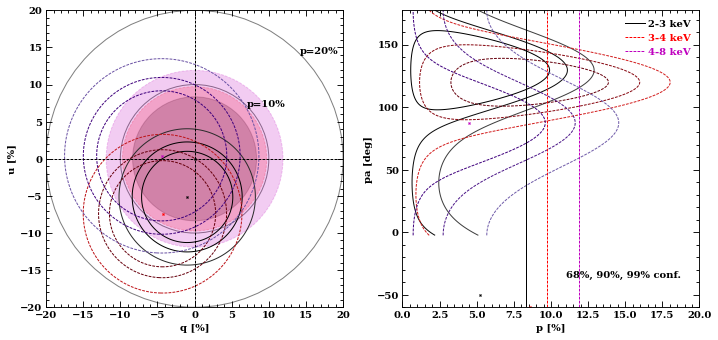

In [146]:
container = cubesm[0]
name = '1es_multi'

fig, (ax,ax2) = plt.subplots(figsize=(11,5),ncols=2)

dy = np.pi/2
x = np.linspace(0,0.2,1600)
y = np.linspace(np.deg2rad(container.PA[2])-dy,
                np.deg2rad(container.PA[2])+dy,1600)
X,Y = np.meshgrid(x,y)
d1 = x[1] - x[0]
d2 = y[1] - y[0]
ax2.set_ylabel('pa [deg]')
ax2.set_xlabel('p [%]')
for i, style in enumerate([('solid',plt.cm.binary,'k','2-3 keV'),
                             ('dashed',plt.cm.Reds,'r','3-4 keV'),
                            ('dashed',plt.cm.Purples,'m','4-8 keV')]):
  Z=pol_posterior(*[X,Y], container.N_EFF[i], 
                  pi=container.PD[i], 
                  phi=np.deg2rad(container.PA[i]), 
                  mu100=container.MU[i])
  c3 = CL(Z, dx=d1, dy=d2, p=0.68)
  c2 = CL(Z, dx=d1, dy=d2, p=0.90)
  c1 = CL(Z, dx=d1, dy=d2, p=0.99)
  cs = ax2.contour(X*100,np.rad2deg(Y),Z, levels=[c1,c2,c3], cmap=style[1],norm=LogNorm(vmin=0.001,vmax=3.2), 
                   linestyles=style[0])
  ax2.errorbar(container.PD[i]*100, container.PA[i], marker='x', markersize=2,color=style[2])
  ax2.axvline(container.MDP_99[i]*100,ls=style[0],color=style[2], label=style[3])
ax2.annotate('68%, 90%, 99% conf.', xy=(0.55,0.1), xycoords='axes fraction')
leg = ax2.legend()
for line, text in zip(leg.get_lines(),leg.get_texts()):
    text.set_color(line.get_color())

ax.errorbar(0,0, marker='x', markersize=2)
for r in [r*10 for r in range(1,10)]:
  cc = plt.Circle((0, 0), r, fill=False, ls='-', alpha=0.5)
  ax.annotate(f"p={r}%",xy=(r/np.sqrt(2),r/np.sqrt(2)))
  ax.add_artist(cc)
ax.axvline(0,ls='--')
ax.axhline(0,ls='--')
ax.set_ylabel('u [%]')
ax.set_xlabel('q [%]')

window = 20
ax.set_ylim(-window,window)
ax.set_xlim(-window,window)

q = np.linspace(-0.2,0.2,1600)
u = np.linspace(-0.2,0.2,1600)

Q,U = np.meshgrid(q,u)
dq = q[1] - q[0]
du = u[1] - u[0]

for i, style in enumerate([('solid',plt.cm.binary,'k'),
                             ('dashed',plt.cm.Reds,'r'),
                            ('dashed',plt.cm.Purples,'m')]):
  Z=qu_posterior(*[Q,U], container.N_EFF[i], 
                  q=container.QN[i], 
                  u=container.UN[i], 
                  mu100=container.MU[i])
  c3 = CL(Z, dx=d1, dy=d2, p=0.68)
  c2 = CL(Z, dx=d1, dy=d2, p=0.90)
  c1 = CL(Z, dx=d1, dy=d2, p=0.99)
  cs = ax.contour(Q*100,U*100,Z, levels=[c1,c2,c3], cmap=style[1],norm=LogNorm(vmin=0.001,vmax=3.2), 
                   linestyles=style[0])
  
  ax.errorbar(container.QN[i]*100, container.UN[i]*100, marker='x', 
              markersize=2, color=style[2])
  cc = plt.Circle((0, 0), container.MDP_99[i]*100, fill=True, color=style[2], 
                  alpha=0.2, ls=style[0])
  ax.add_artist(cc)
  
plt.savefig("plots/" + name + ".pdf",format="pdf", bbox_inches="tight")

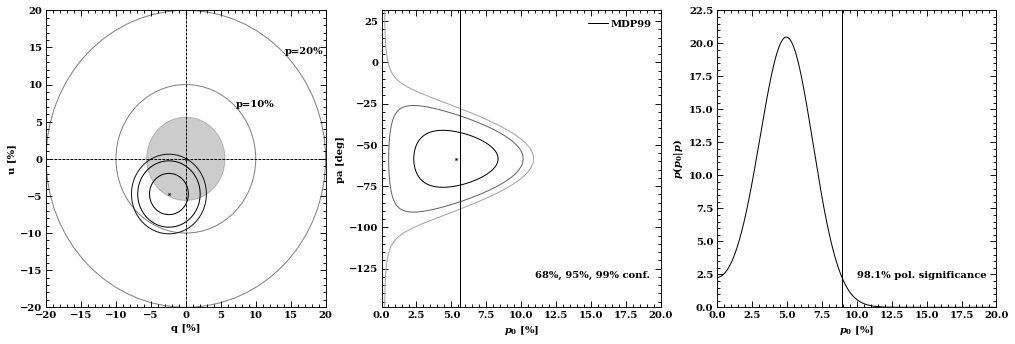

In [145]:
fig, (ax,ax2,ax3) = plt.subplots(figsize=(16,5),ncols=3)
name = '1es_weight'
cube = cubes_subt[2]

dy = np.pi/2
x = np.linspace(0,0.2,1600)
y = np.linspace(np.deg2rad(cube.PA)-dy,
                np.deg2rad(cube.PA)+dy,1600)
X,Y = np.meshgrid(x,y)
d1 = x[1] - x[0]
d2 = y[1] - y[0]
ax2.set_ylabel('pa [deg]')
ax2.set_xlabel(r'$p_0$ [%]')
for container, style in zip([cube],
                            [('solid',plt.cm.binary,'k','MDP99'),]):
  Z=pol_posterior(*[X,Y], container.N_EFF, 
                  pi=container.PD, 
                  phi=np.deg2rad(container.PA), 
                  mu100=container.MU)
  c3 = CL(Z, dx=d1, dy=d2, p=0.68)
  c2 = CL(Z, dx=d1, dy=d2, p=0.95)
  c1 = CL(Z, dx=d1, dy=d2, p=0.99)
  cs = ax2.contour(X*100,np.rad2deg(Y),Z, levels=[c1, c2, c3], cmap=style[1],norm=LogNorm(vmin=0.1,vmax=10.2), 
                   linestyles=style[0])
  ax2.errorbar(container.PD*100, container.PA, marker='x', markersize=2,color=style[2])
  ax2.axvline(container.MDP_99*100,ls=style[0],color=style[2], label=style[3])
  
  marginal = np.sum(Z*d2,axis=0)
  integral = np.sum(marginal*d1)
  marginal /= integral

  ax3.plot(x*100, marginal)
  _, low, high = CL(marginal, dx=d1, p=0.981, tol=0.0005, max_iter=20000)
  ax3.axvline(x[high]*100)
  ax3.set_ylabel(r'$p(p_0|p)$')
  ax3.set_xlabel(r'$p_0$ [%]')
  ax3.annotate('98.1% pol. significance', xy=(0.5,0.1), xycoords='axes fraction')
  
# ax2.contour([x*100 for x in Plot.x()], Plot.y(), Plot.z(), levels=Plot.contourLevels(),
#             cmap=plt.cm.Greens, norm=LogNorm(vmin=500, vmax=530), label='Xspec')
ax2.annotate('68%, 95%, 99% conf.', xy=(0.55,0.1), xycoords='axes fraction')
leg = ax2.legend()
for line, text in zip(leg.get_lines(),leg.get_texts()):
    text.set_color(line.get_color())

ax.errorbar(0,0, marker='x', markersize=2)
for r in [r*10 for r in range(1,10)]:
  cc = plt.Circle((0, 0), r, fill=False, ls='-', alpha=0.5)
  ax.annotate(f"p={r}%",xy=(r/np.sqrt(2),r/np.sqrt(2)))
  ax.add_artist(cc)
ax.axvline(0,ls='--')
ax.axhline(0,ls='--')
ax.set_ylabel('u [%]')
ax.set_xlabel('q [%]')

window = 20
ax.set_ylim(-window,window)
ax.set_xlim(-window,window)

q = np.linspace(-0.2,0.2,1600)
u = np.linspace(-0.2,0.2,1600)

Q,U = np.meshgrid(q,u)
dq = q[1] - q[0]
du = u[1] - u[0]

for container, style in zip([cube],
                            [('solid',plt.cm.binary,'k'),]):#('dashed','r'),('dotted','m'),('dashed','b')]):
  Z=qu_posterior(*[Q,U], container.N_EFF, 
                  q=container.QN, 
                  u=container.UN, 
                  mu100=container.MU)
  c3 = CL(Z, dx=dq, dy=du, p=0.68)
  c2 = CL(Z, dx=dq, dy=du, p=0.95)
  c1 = CL(Z, dx=dq, dy=du, p=0.99)
  cs = ax.contour(Q*100,U*100, Z, levels=[c1, c2, c3], cmap=style[1], norm=LogNorm(vmin=0.1,vmax=10.2), 
                   linestyles=style[0])
  ax.errorbar(container.QN*100, container.UN*100, marker='x', markersize=2,color=style[2])

  cc = plt.Circle((0, 0), container.MDP_99*100, fill=True, color=style[2], 
                  alpha=0.2, ls=style[0])
  ax.add_artist(cc)
  
  
plt.savefig("plots/" + name + ".pdf",format="pdf", bbox_inches="tight")